# 08 - Conditional Normalizing Flow for Joint and Conditional sampling. 
This notebook is the second in the tutorial series for InvertibleNetworks.jl. In this tutorial, we will show how to train a Normalizing Flow (NF) to sample from a joint distribution $p(x,y)$. Pairing joint distribution training with conditional normalizing flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the conditional normalizing flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions




```julia
Σ_post = inv(Λ_x + A'*Λ_ϵ*A)
R = cholesky(Σ_post, check=false).L
```

### <font color=B8860B>What do these two lines of julia code do?</font>

These two lines of Julia code are performing operations related to statistical computing, specifically in the context of Bayesian inference or linear regression models where covariance matrices and precision matrices are involved.

#### Line 1: Compute the Posterior Covariance Matrix

```julia
Σ_post = inv(Λ_x + A'*Λ_ϵ*A)
```

- **`Λ_x`**: <font color=cornflowerblue>This is typically the precision matrix of the prior distribution. In Bayesian terms, precision is the inverse of variance (or covariance in the multivariate case). Therefore, `Λ_x` represents how much we know about the parameters before observing any data,</font> with higher values indicating higher confidence (lower variance).

- **`Λ_ϵ`**: This represents the precision matrix of the observation noise. It quantifies the uncertainty in the measurements or observations.

- **`A`**: This is usually a design matrix that relates the observations to the model parameters. In linear regression, for example, `A` would contain the independent variables (or predictors).

- **`Σ_post`**: The result is the posterior covariance matrix of the parameters after observing data. This formula is derived from the Bayesian updating rule in the context of Gaussian distributions, where the posterior distribution's covariance (or precision) is updated based on the prior information, the data observed, and the model assumed. The operation `A'*Λ_ϵ*A` computes the weighted sum of squares (or "information") contributed by the data, which is then added to the prior precision matrix `Λ_x`. The inverse of this sum gives the posterior covariance matrix, indicating the uncertainty in the parameter estimates after data observation.

#### Line 2: Cholesky Decomposition of the Posterior Covariance Matrix

```julia
R = cholesky(Σ_post, check=false).L
```

- The `cholesky` function computes the Cholesky decomposition of the posterior covariance matrix `Σ_post`. The Cholesky decomposition is a factorization of a symmetric, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose.

- **`check=false`**: This argument tells the function not to check if the matrix is positive definite. This can be useful if you are certain of your matrix's properties and want to avoid the computational cost of this check, but it should be used with caution as it can lead to incorrect results if the matrix is not positive definite.

- **`.L`**: After performing the Cholesky decomposition, `.L` accesses the lower triangular matrix resulting from the decomposition.

- **`R`**: This variable stores the lower triangular matrix `L` from the Cholesky decomposition of `Σ_post`. In some contexts, this matrix is used for efficiently sampling from the posterior distribution, solving linear systems, or computing determinants.

In summary, these lines calculate the posterior covariance matrix of model parameters given prior information and observed data, and then perform a Cholesky decomposition on this matrix to obtain a lower triangular matrix used in further computations or analyses.

### <font color=B8860B>I learned that the way seed works is every time you call `rand`, the seed roll over to the next. So, to ensure you get the same result when you call random, you have to set Random.seed!(1) every time you call rand. Is that right?</font>

Yes, your understanding is mostly correct, with a slight nuance. When you set a seed using Random.seed!(seed_value) in Julia (or similar functions in other programming languages), you initialize the state of the random number generator (RNG) to a deterministic starting point. Every time you call a function like rand(), it generates a new random number based on the current state of the RNG, and then it updates the RNG's state so that the next call to rand() will produce a different number. This process ensures that the sequence of random numbers is reproducible when you start from the same seed.

<u>So, if you want to ensure that a specific call to rand() always produces the same result each time you run your script or notebook, you would indeed need to reset the seed immediately before that call. This way, the RNG's state is always the same at that point in the code, leading to the same "random" number being generated.</u>

However, constantly resetting the seed can also lead to less randomness in parts of your program where you might need more unpredictability. Typically, you'd set the seed once at the beginning of an experiment, simulation, or analysis to ensure reproducibility of the results while still benefiting from the randomness in the operations that follow. Resetting the seed before every random operation is more common in a debugging context or when trying to demonstrate a specific behavior deterministically.

###

Some results:

* seed = 1: ($30$ epochs) `n_train=100`, `repeat_train=2` or `=3` the results are good. `n_train=75`, `repeat_train=2` is a counter example.
* seed = 2: ($30$ epochs) When `n_train` $\le 60$, most are pretty close. `n_train=30` wins a lot. `n_train=25` both got bad fit. Sampling two realizations of noise wins a little bit. Above `n_train` $\ge$ 60 the results are pretty close.
* seed = 3: ($30$ epochs) Sampling two realizations of noise almost always win except when `n_train=100`, which is hard to tell. For `n_train` $\ge 100$, the dataset is more than enough and the fit is always close to the true posterior.

In [1]:
using InvertibleNetworks
using LinearAlgebra
using Distributions
using PyPlot
using Flux
using Random

PyPlot.rc("font", family="serif"); 

In [2]:
seed = 2

# Model and data dimension
dim_model = 2
dim_data  = 2

# Prior distribution
μ_x = 3.14f0*ones(Float32, dim_model)
σ_x = 1.0f0
Σ_x = σ_x^2*I
Λ_x = inv(Σ_x)

π_x = MvNormal(μ_x, Σ_x)

# Distribution of noise
μ_ϵ = 0.0f0*ones(Float32, dim_data)
σ_ϵ = 0.2f0
Σ_ϵ = σ_ϵ^2*I
Λ_ϵ = inv(Σ_ϵ)

π_ϵ = MvNormal(μ_ϵ, Σ_ϵ)

# Forward operator
Random.seed!(seed)
A = randn(Float32, dim_data, dim_model) #/ sqrt(dim_model*1.0f0)

# Analytic posterior distribution
Σ_post = inv(Λ_x + A'*Λ_ϵ*A)
R = cholesky(Σ_post, check=false).L
standard_normal = MvNormal(zeros(Float32, dim_model), 1.0f0*I)

function post_dist_sample(y)
  return R*rand(standard_normal) + post_dist_mean(reshape(y_test,:,size(y_test)[end]))[:]
end

function post_dist_mean(y)
    Σ_post*(A'*Λ_ϵ*(y) + Λ_x*μ_x)
end

post_dist_mean (generic function with 1 method)

In [3]:
nx = 1  # Express n-Dim variables as n channels
ny = 1  # Express n-Dim variables as n channels
n_in = dim_model  # Express n-Dim variables as n channels
n_train = 35
n_noise = n_train

if n_noise/n_train > 1
    repeat_train = Integer(n_noise/n_train)
    repeat_noise = 1
else
    repeat_train = repeat_noise = 2
end

X_train1 = rand(π_x, n_train)
X_train = reshape(X_train1, nx, ny, dim_model, n_train)
e_train = rand(π_ϵ, n_noise)

X_train1 = cat([X_train1 for _ in 1:repeat_train]..., dims=2)
X_train = cat([X_train for _ in 1:repeat_train]..., dims=4)
e_train = cat([e_train for _ in 1:repeat_noise]..., dims=2)

Y_train = reshape(A * X_train1 + e_train, nx, ny, dim_model, n_noise*repeat_noise);

In [4]:
println(n_train)
println(n_noise)
println(repeat_train)
println(repeat_noise)

35
35
2
2


# Prior distribution - Rosenbrock

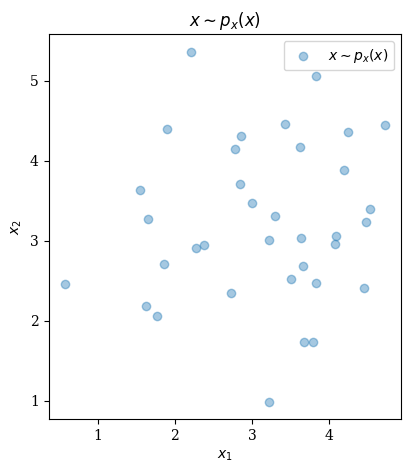

In [1636]:
plot_num = min(100, n_train)

fig = figure(figsize=(10,5));
subplot(1,2,1); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

# Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add gaussian additive noise and the result will be our observed data.   
$$y = Ax + \epsilon$$

Even though we will choose an $A$ that will be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $p(x|y)$, the conditional distribution. In this context, this is also called the posterior distribution. 

Note: we could also use a non-linear operator.

First we make an our linear measurement operator:

In [1637]:
# # Linear forward operator
# A = randn(Float32,2,2)
# A = A / (2*opnorm(A)); 

Then use this operator to make training data $Y_{\rm train}$

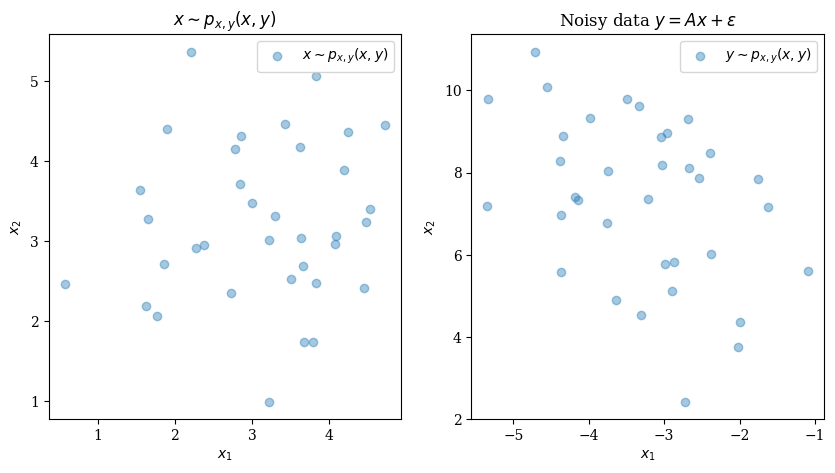

In [1638]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Training a conditional normalizing flow. 

<font color=orange>A conditional normalizing flow is trained by learning the joint distribution $p(x,y)$ this is done in the same way as a non-conditional normalizing flow is trained by minimizing the negative log likelihood (Refer to Tutorial notebook 01 for more details.)</font>

In [1639]:
function loss(H, X, Y)
    batch_size = size(X)[end]
    
    Zx, Zy, lgdet = H.forward(X, Y)
    l2_loss = 0.5*norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [1640]:
@which tensor_cat

InvertibleNetworks

In [1641]:
function get_minibatches(X, Y, batch_size)
    n_samples = size(X, 4)  # Assuming the number of samples is the 4th dimension
    indices = randperm(n_samples)
    minibatches = []

    for i in 1:batch_size:n_samples
        batch_indices = indices[i:min(i+batch_size-1, n_samples)]
        X_batch = X[:, :, :, batch_indices]
        Y_batch = Y[:, :, :, batch_indices]
        push!(minibatches, (X_batch, Y_batch))
    end

    return minibatches
end

batch_size = 64
minibatches = get_minibatches(X_train, Y_train, batch_size);

In [1642]:
# Define network

n_hidden = 64
batchsize = 64
depth = 10

# Construct HINT network
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
# maxiter = 900
nepochs = 30
lr      = 5f-4
lr_decay_step = 90

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.ADAM(lr))

loss_l2_list    = []
loss_lgdet_list = []

for ep = 1:nepochs
    for (X, Y) in minibatches
        
        losses = loss(H, X, Y)
        # loss_l2_list[j]    = losses[1]
        # loss_lgdet_list[j] = losses[2]
        push!(loss_l2_list, losses[1])
        push!(loss_lgdet_list, losses[2])

        # print("Iter : iteration=", j, "/", maxiter, ", batch=", 
        #         "; f l2 = ",   loss_l2_list[j], 
        #         "; f lgdet = ",loss_lgdet_list[j], 
        #         "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")

        # Update params
        for p in get_params(H)
            Flux.update!(opt, p.data, p.grad)
        end
    end
end

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $Zx, Zy = H_{\theta}(Z,Y)$ with qq plots 
- as a heuristic simply observe $Zx, Zy = H_{\theta}(X, Y)$ until it looks normal under the eyeball norm. 

Note: joint distributions are harder to learn than marginal distributions. There are a few reasons including the larger dimensionality and the fact that learning a joint distribution implicitly also learns a conditional distribution. 

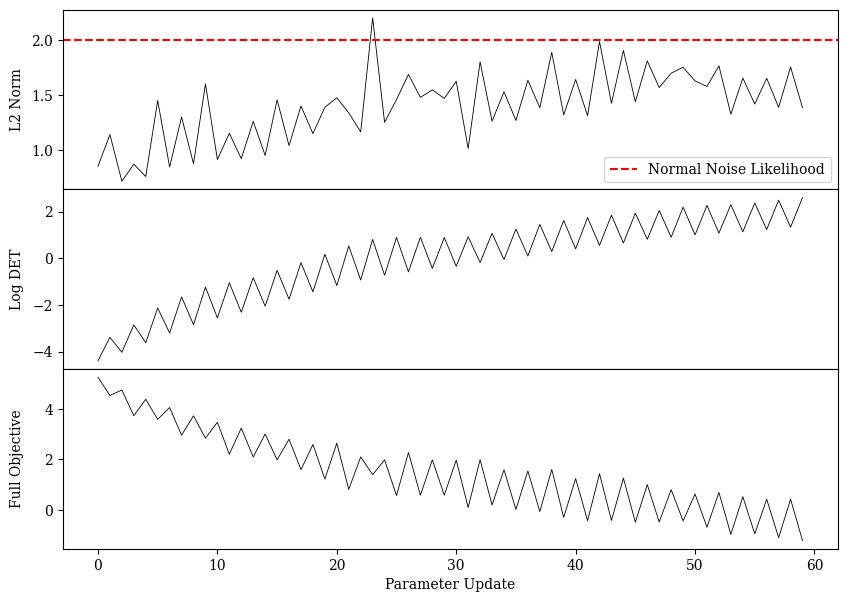

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [1643]:
gt_l2 = 0.5*nx*ny*n_in*2 #l2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Conditional Normalizing Flow 

The first step in testing a normalizing flow is to understand what prior it has learned. In this case, we trained our network to generate samples from a joint distribution so we will first check that these generative samples look like 
 
We start with normal gaussian variables $Zx, Zy \sim N(0, I)$

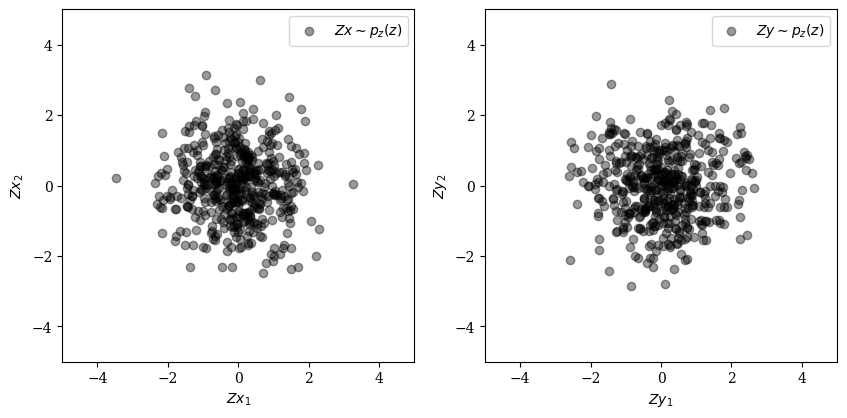

In [1644]:
num_test_samples = 500;
Zx_test = randn(Float32,nx,ny,n_in, num_test_samples);
Zy_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(figsize=(10,5)); 
ax1 = subplot(1,2,1)
scatter(Zx_test[1,1,1,:], Zx_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zx \sim p_{z}(z)");
xlabel(L"Zx_1"); ylabel(L"Zx_2"); xlim(-5,5); ylim(-5,5);
legend(); ax1.set_aspect(1);

ax2 = subplot(1,2,2)
scatter(Zy_test[1,1,1,:], Zy_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zy \sim p_{z}(z)");
xlabel(L"Zy_1"); ylabel(L"Zy_2"); xlim(-5,5); ylim(-5,5);
legend(); ax2.set_aspect(1);

Make generative samples from the joint distribution by passing both Z variables through the inverse network $ x,  y = H^{-1}_\theta(Zx,Zy)$ 

In [1645]:
X_test, Y_test = H.inverse(Zx_test, Zy_test);

In [1646]:
size(X_test)

(1, 1, 2, 500)

Visually compare generative joint samples with joint samples from the ground truth density $x, y \sim p(x,y) $

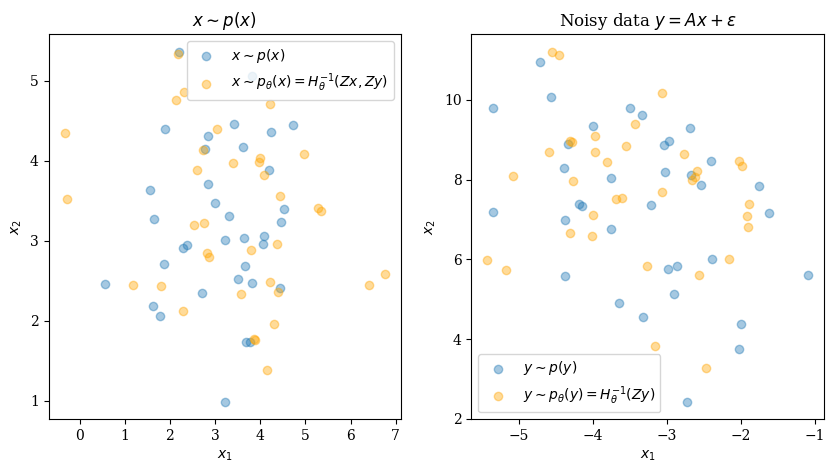

In [1647]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x)");
scatter(X_test[1,1,1,1:plot_num], X_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = H_\theta^{-1}(Zx, Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(y)");
scatter(Y_test[1,1,1,1:plot_num], Y_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"y \sim p_{\theta}(y) = H_\theta^{-1}(Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();
savefig("08_plots/seed$seed" * "/generated_sample/mv_generated_sample_seed=$seed" * "_n_train=$n_train" * "_n_noise=$n_noise" * "_repeat_train=$repeat_train" * "_repeat_noise=$repeat_noise")

In [1648]:
println("08_plots/$seed" * "/mv_generated_sample_seed=$seed" * "_n_train=$n_train" * "_n_noise=$n_noise" * "_repeat_train=$repeat_train" * "_repeat_noise=$repeat_noise")

08_plots/2/mv_generated_sample_seed=2_n_train=35_n_noise=35_repeat_n_train=2_repeat_n_noise=2


## Test inference of inverse problem given noisy data

After verifying that training was successful we can proceed to perform inference of the inverse problem. We will first observe a single data $y$:

In [1649]:
# x_star  = sample_banana(1);
# y_obs = reshape(A*vec(x_star), nx, ny, n_in, 1);
# y_obs += .2f0*randn(Float32, size(y_obs));

Random.seed!(seed)   # reset seed to ensure we are looking at the same `x_star` in each experiment
x_star = rand(π_x, 1)
y_obs = reshape(x_star, nx, ny, dim_model, 1)
e_train = rand(π_ϵ, 1)
y_obs = reshape(A * x_star + e_train, nx, ny, dim_model, 1)
x_star = reshape(x_star, nx, ny, dim_model, 1);

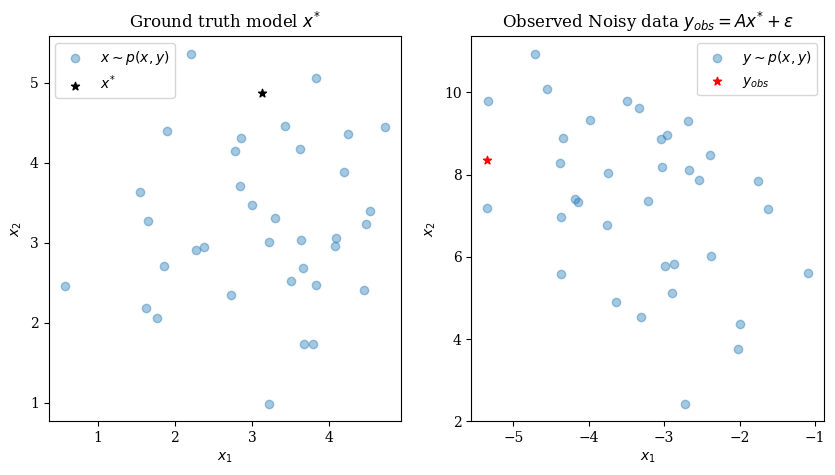

In [1650]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [1651]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [1652]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

y_test = y_obs
X_post_true = zeros(Float32,1,1,dim_model,cond_sampling_size)
for i in 1:cond_sampling_size
    X_post_true[:,:,:,i] = post_dist_sample(y_test)
end

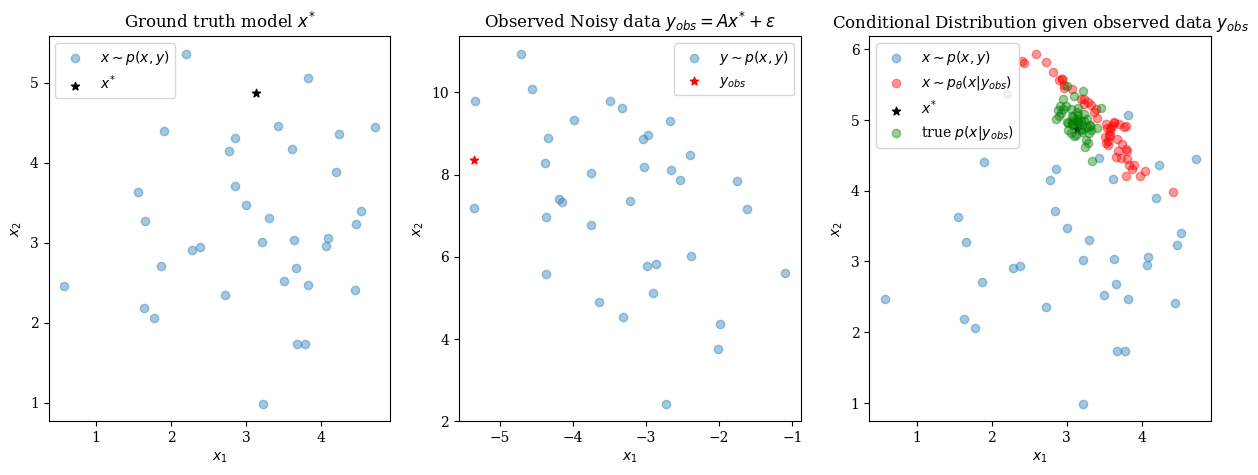

In [1653]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
scatter(X_post_true[1,1,1,:], X_post_true[1,1,2,:]; alpha=0.4, color="green", label = "true "*L"p(x | y_{obs})");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend()

savefig("08_plots/seed$seed" * "/mv_posterior_seed=$seed" * "_n_train=$n_train" * "_n_noise=$n_noise" * "_repeat_train=$repeat_train" * "_repeat_noise=$repeat_noise")

In [1654]:
size(X_post_true) == size(X_post)

true

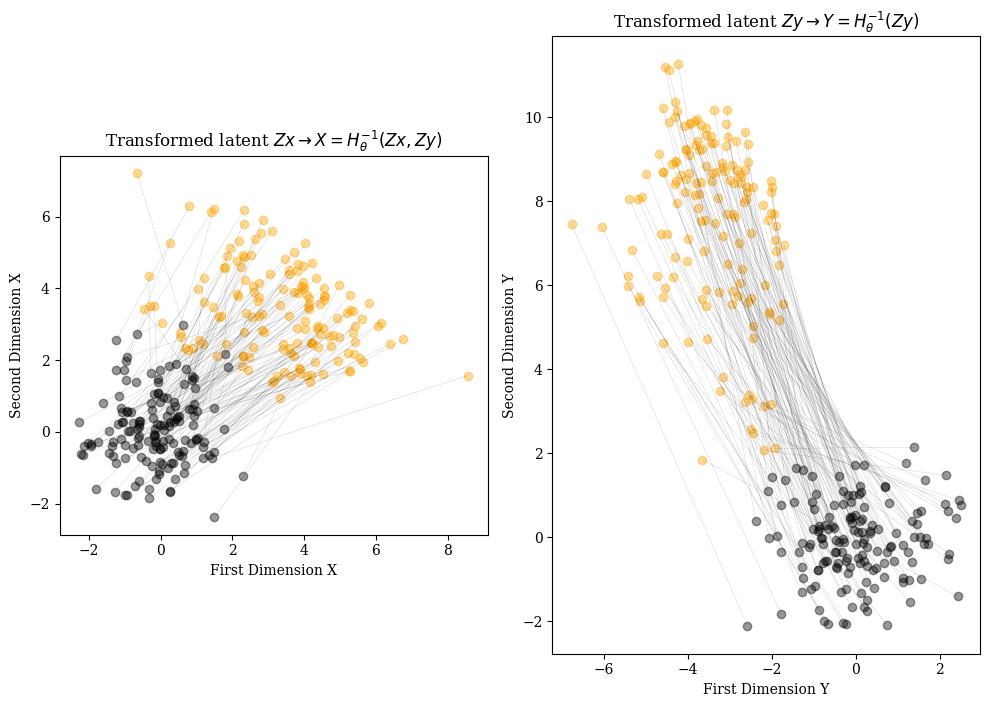

In [1655]:
trans_num = 150
start_points = [(Zx_test[1,1,1,i], Zx_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

# Plot transformed Latent Zx
fig = figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1); title(L"Transformed latent $Zx \rightarrow X=H^{-1}_\theta(Zx, Zy)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension X"); ylabel("Second Dimension X");
# ylim(-2.5,20); xlim(-2.5,2.5); 
ax.set_aspect(1)

# Plot transformed Latent Zy
start_points = [(Zy_test[1,1,1,i], Zy_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(Y_test[1,1,1,i], Y_test[1,1,2,i]) for i in 1:trans_num]

ax = fig.add_subplot(1,2,2); title(L"Transformed latent $Zy \rightarrow Y=H^{-1}_\theta(Zy)$");
for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension Y"); ylabel("Second Dimension Y");
ax.set_aspect(1)

tight_layout()

In [1656]:
# # get ground truth mean
# mean_true = post_dist_mean(y_test[1,1,:])

# # cond_sampling_size = 20

# # Get ground truth samples from posterior
# X_post_true = zeros(Float32,1,1,dim_model,cond_sampling_size)
# for i in 1:cond_sampling_size
#     X_post_true[:,:,:,i] = post_dist_sample(y_test)
# end